In [ ]:
# Instals necessary packages
# BiocManager::install("dorothea")
# install.packages("pheatmap")
# BiocManager::install('limma')

In [1]:
# Load dependencies ----
library(Seurat)
library(dorothea)
library(dplyr)
library(tibble)
library(pheatmap)
library(tidyr)
library(viper)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, 

### Data Visualization

In [2]:
# Read data
df <- readRDS('dbClust_0130.rds')

In [3]:
# Data Visualization  ----
#Roundabout way to add response group to metadata
df[["final.clust"]] <- Idents(object = df)
Idents(df) <- 'orig.ident'
response.group <- c('NR','NR','NR','NR','NR','NR','R','R','R','R','R')
names(response.group) <- levels(df)
df <- RenameIdents(df, response.group)
df[["response.group"]] <- Idents(object = df)

#Annotates cell types based on manual curation
Idents(df) <- 'final.clust'
ann.cell.type <- c('NK', 'Malignant', 'Endothelial', 'T cells', 'Macrophages',
                   'Malignant', 'B cells', 'Malignant', 'CAFs', 'Dendritic',
                   'Plasma B')
names(ann.cell.type) <- levels(df)
df <- RenameIdents(df, ann.cell.type)
df[["ann.cell.type"]] <- Idents(object = df)

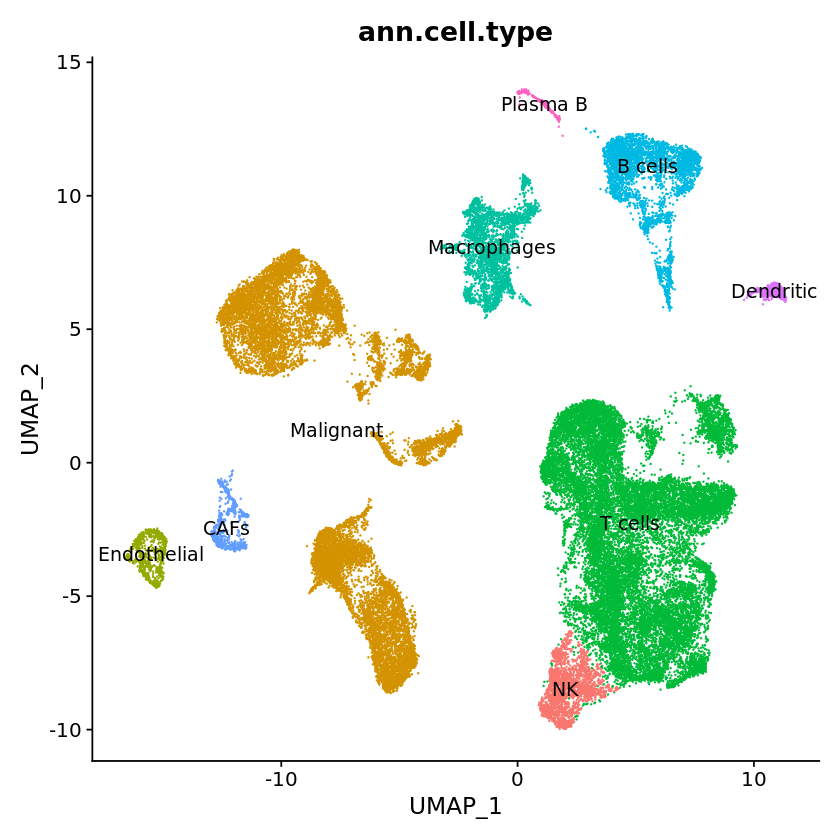

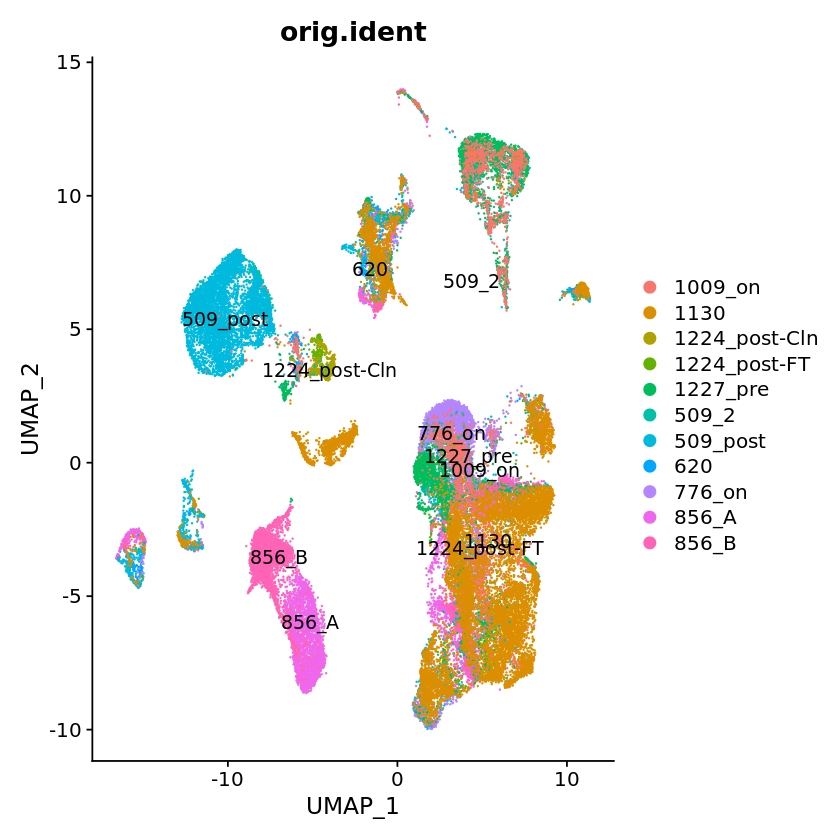

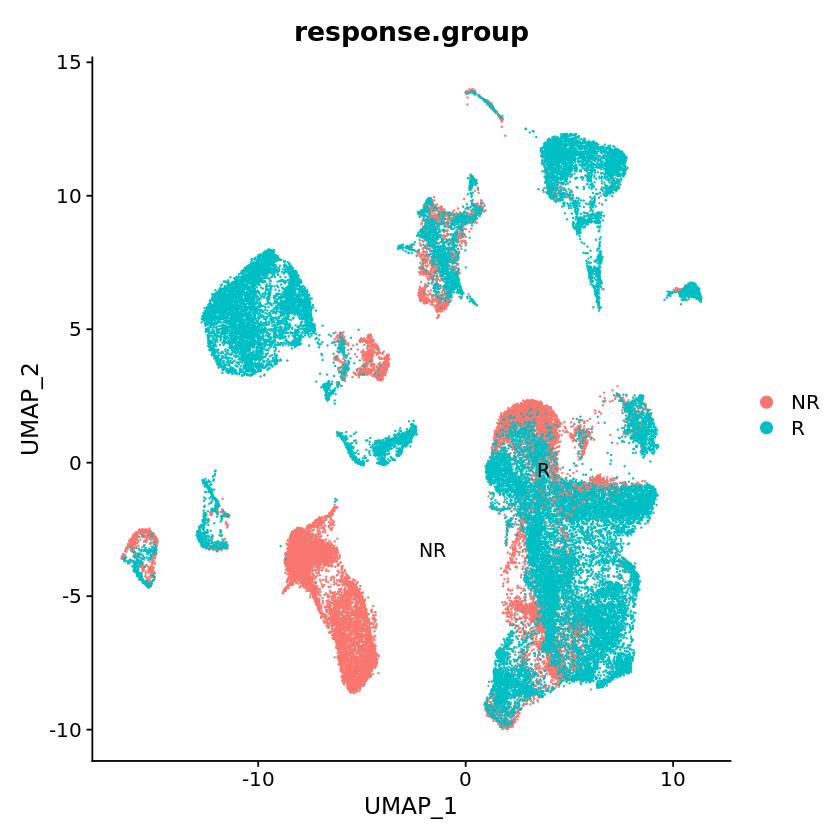

In [4]:
#Visualizes UMAP based on various metadata groups
DimPlot(df, reduction = 'umap', group.by='ann.cell.type', label=TRUE) + NoLegend()
DimPlot(df, reduction = 'umap', group.by='orig.ident', label=TRUE)
DimPlot(df, reduction = 'umap', group.by='response.group' , label=TRUE)

### Cluster cells based on TF Profile (DoRothEA + VIPER)

In [5]:
# Read Dorothea Regulons for Humans
dorothea_regulon_human <- get(data("dorothea_hs", package = "dorothea"))

# Obtain regulons based on interactions with confidence level A, B and C
regulon <- dorothea_regulon_human %>%
  dplyr::filter(confidence %in% c("A","B","C"))

In [6]:
# Compute Viper Scores 
df <- run_viper(df, regulon,
                  options = list(method = "scale", minsize = 4, 
                                 eset.filter = FALSE, cores = 1, 
                                 verbose = TRUE))


Computing the association scores

Computing regulons enrichment with aREA



  |======================================================================| 100%

In [13]:
# Saves the RSD file with Dorothea analysis
DefaultAssay(object = df) <- "dorothea"
saveRDS(df, file = "dbClust_0130_dorothea_processed.rds")

In [ ]:
# Copies data to GBucket
bucket <- Sys.getenv('WORKSPACE_BUCKET')
save.path = "/"
command = paste0("gsutil cp dbClust_0130_dorothea_processed.rds ", bucket, save.path)
system(command, intern=TRUE)

# Let's verify everything landed where it should!
system(paste0("gsutil ls -r ", bucket, save.path), intern=TRUE)

In [29]:
# Recluster the data based on TF Activity score
# df <- readRDS("dbClust_0130_dorothea_processed.rds") #Load processed rds if needed
df <- ScaleData(df)
df <- RunPCA(df, features = rownames(df), verbose = FALSE)
df <- FindNeighbors(df, dims = 1:10, verbose = FALSE)
df <- FindClusters(df, resolution = 0.5, verbose = FALSE)

Centering and scaling data matrix



In [30]:
df <- RunUMAP(df, dims = 1:10, umap.method = "uwot", metric = "cosine")

df.markers <- FindAllMarkers(df, only.pos = TRUE, min.pct = 0.25, 
                               logfc.threshold = 0.25, verbose = TRUE)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
18:05:37 UMAP embedding parameters a = 0.9922 b = 1.112

18:05:37 Read 46089 rows and found 10 numeric columns

18:05:37 Using Annoy for neighbor search, n_neighbors = 30

18:05:37 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

18:05:43 Writing NN index file to temp file /tmp/Rtmp2AhnWZ/file2c8511285

18:05:43 Searching Annoy index using 1 thread, search_k = 3000

18:06:08 Annoy recall = 100%

18:06:10 Commencing smooth kNN distance calibration using 1 thread

18:06:12 Initializing from 

In [40]:
# Saves clustering based on TF activity
df[["tf.cluster"]] <- Idents(object = df)

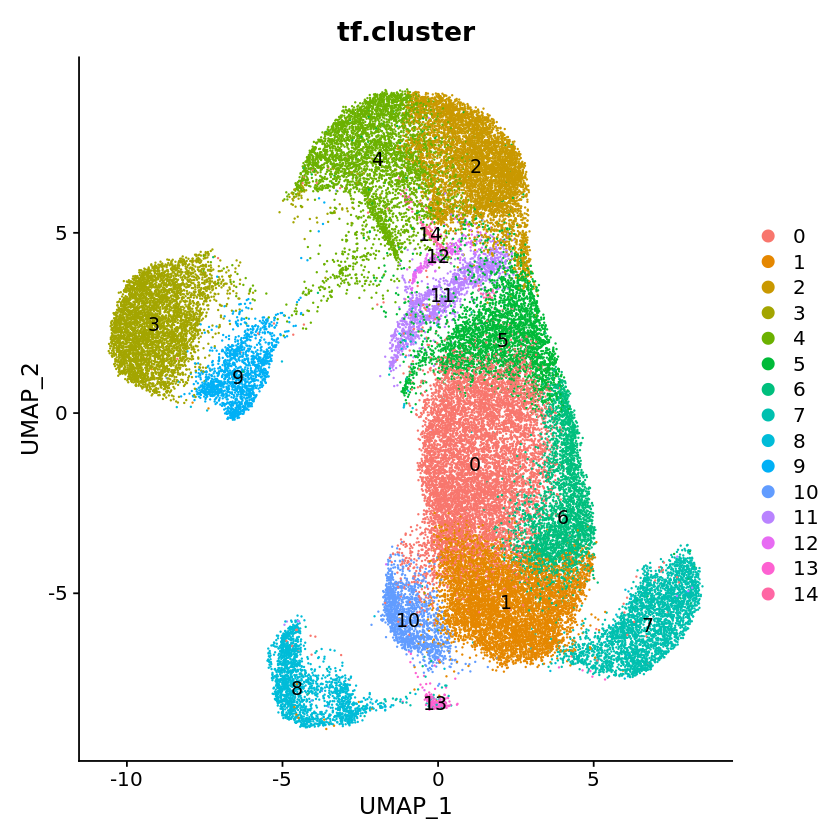

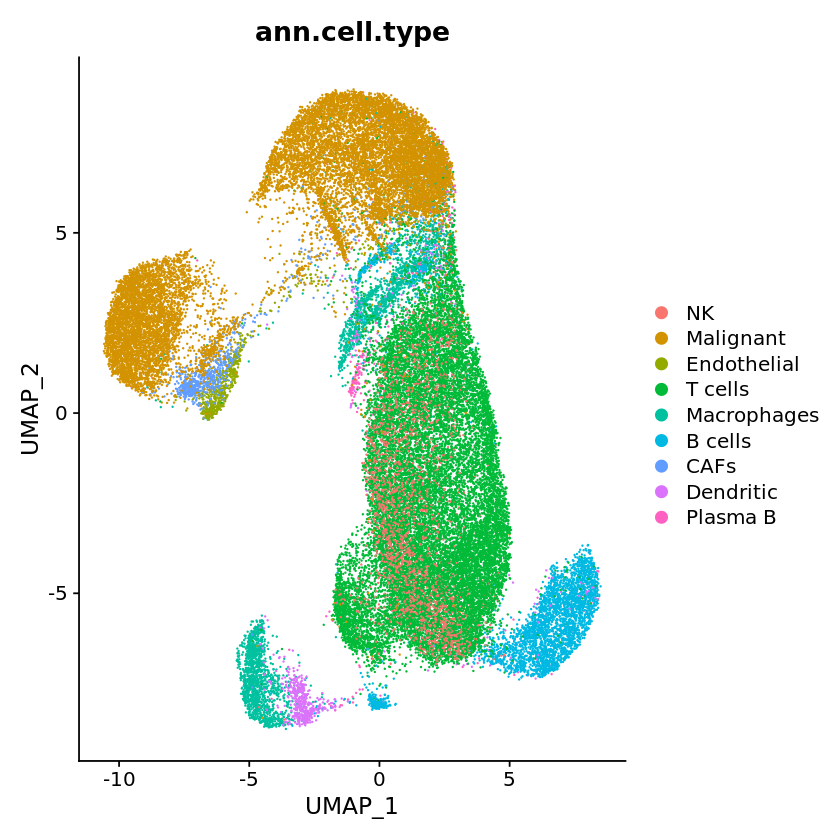

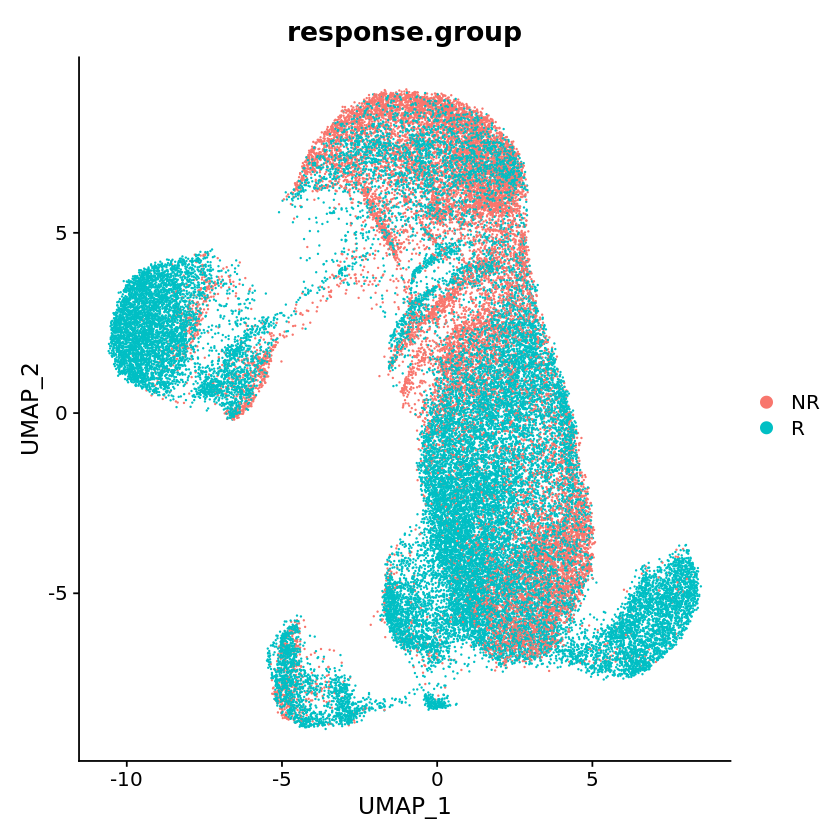

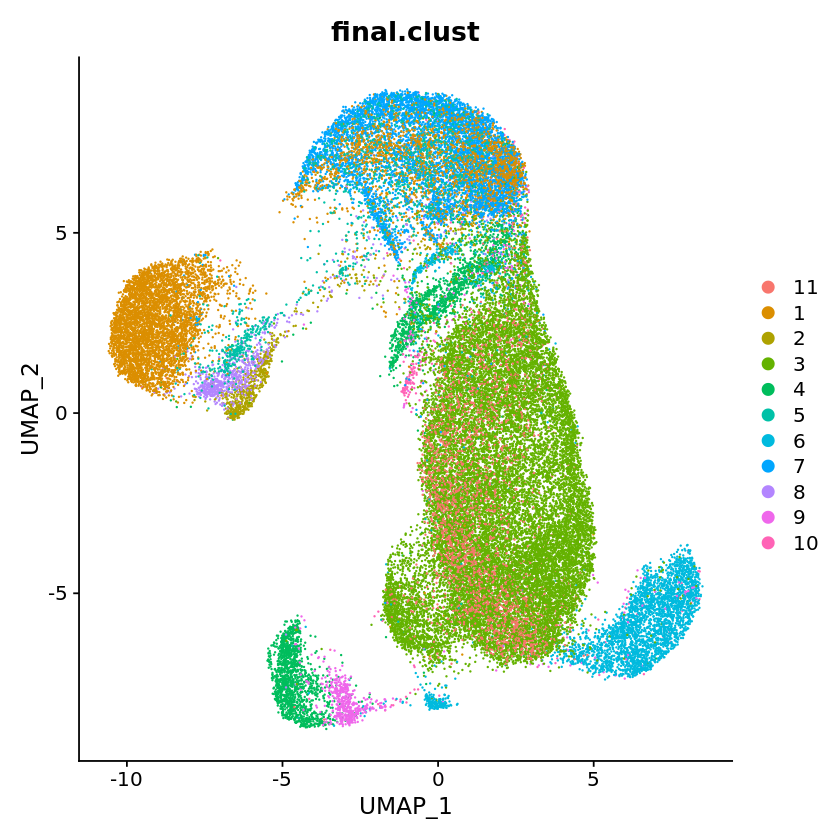

In [52]:
# Visualizes UMAP based on TF activity
DimPlot(df, reduction = 'umap', group.by='tf.cluster', label=TRUE)
DimPlot(df, reduction = 'umap', group.by='ann.cell.type', label=FALSE)
DimPlot(df, reduction = 'umap', group.by='response.group', label=FALSE)
DimPlot(df, reduction = 'umap', group.by='final.clust', label=FALSE)

It looks like a penguin

TF signature of NK cells and T cells overlap above  
May make sense if they are using the same regulatory pathway to attack cancer -> cytotoxic?
    Would be interesting to see in NR vs R




TO DO NEXT:

Look at the TF enrichment by NR/R  
Separate the object into NR/R and then redo? Prob not since it does the TF enrichment by sc  
Separate the data post TF activity calculation, scale, cluster, visualize. Maybe theres gonna be a difference?  
A difference in the NK/T cell pattern from above would be cool

Look at TF activity based on cell types? original?  
Would it be worthwhile to look at differentially expressed genes for each cluster and try a manual annontate?  
Look at the pathways associated with the top hits below? Maybe more beneficial once the NR/R split is done



In [109]:
# Transform scaled Viper scores to dataframe
viper_scores_df <- GetAssayData(df, slot = "scale.data", 
                                    assay = "dorothea") %>%
  data.frame(check.names = F) %>%
  t()

# Create a data frame containing the cells and their clusters
CellsClusters <- data.frame(cell = names(Idents(df)), 
#                             cell_type = as.character(Idents(df)),
                            cell_type = unlist(df[["ann.cell.type"]], use.names=FALSE),  
#                             cell_type = unlist(df[["response.group"]], use.names=FALSE),
                            check.names = F)

# Create a data frame with Viper scored per cell and its clusters
viper_scores_clusters <- viper_scores_df  %>%
  data.frame() %>% 
  rownames_to_column("cell") %>%
  gather(tf, activity, -cell) %>%
  inner_join(CellsClusters)

# Summarize the Viper scores by cellpopulation
summarized_viper_scores <- viper_scores_clusters %>% 
  group_by(tf, cell_type) %>%
  summarise(avg = mean(activity),
            std = sd(activity))

Joining, by = "cell"

`summarise()` has grouped output by 'tf'. You can override using the `.groups` argument.



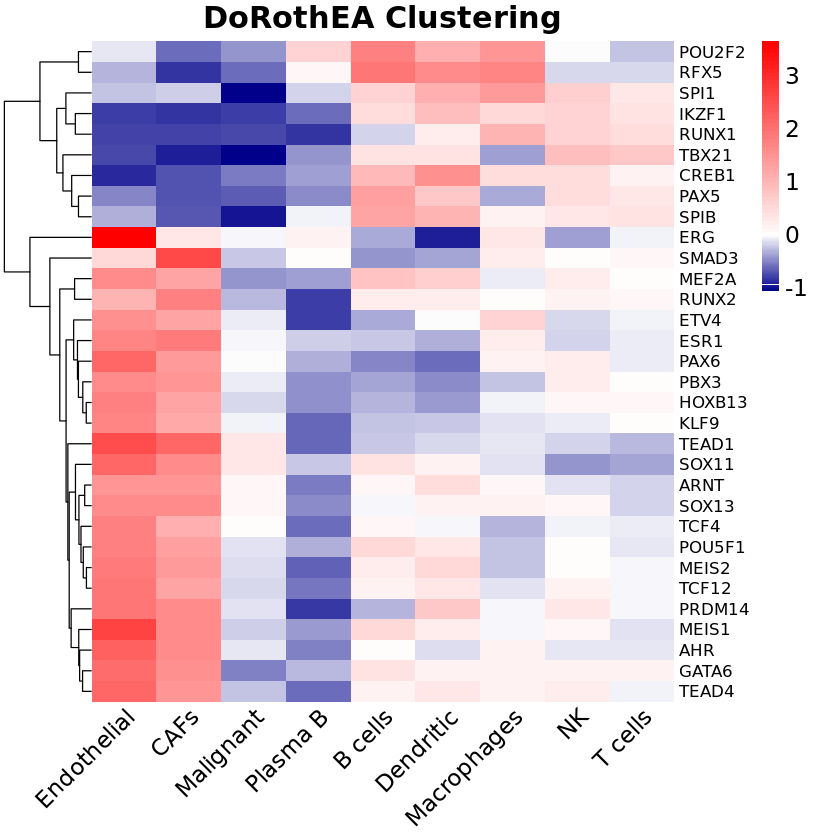

In [111]:
# Select the 20 most variable TFs. (20*14 populations)
highly_variable_tfs <- summarized_viper_scores %>%
  group_by(tf) %>%
  mutate(var = var(avg))  %>%
  ungroup() %>%
  top_n(20*14, var) %>%
  distinct(tf)

# Prepare the data for the plot
summarized_viper_scores_df <- summarized_viper_scores %>%
  semi_join(highly_variable_tfs, by = "tf") %>%
  dplyr::select(-std) %>%   
  spread(tf, avg) %>%
  data.frame(row.names = 1, check.names = FALSE) 
palette_length = 100
my_color = colorRampPalette(c("Darkblue", "white","red"))(palette_length)

my_breaks <- c(seq(min(summarized_viper_scores_df), 0, 
                   length.out=ceiling(palette_length/2) + 1),
               seq(max(summarized_viper_scores_df)/palette_length, 
                   max(summarized_viper_scores_df), 
                   length.out=floor(palette_length/2)))

viper_hmap <- pheatmap(t(summarized_viper_scores_df),fontsize=14, 
                       fontsize_row = 10, 
                       color=my_color, breaks = my_breaks, 
                       main = "DoRothEA Clustering", angle_col = 45,
                       treeheight_col = 0,  border_color = NA) 

In [101]:
# list.files() #List at files in directory

